# Logistic Regression with Differential Privacy

We start by importing the required libraries and modules and collecting the data that we need from the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

In [39]:
import diffprivlib.models as dp
import numpy as np
from sklearn.linear_model import LogisticRegression

In [40]:
X_train = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=",")

y_train = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=",")

In [41]:
np.unique(y_train)

array([' <=50K', ' >50K'], dtype='<U6')

Let's also collect the test data from Adult to test our models once they're trained.

In [42]:
X_test = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=",", skip_header=1)

y_test = np.genfromtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=",", skip_header=1)

# Must trim trailing period "." from label
y_test = np.array([a[:-1] for a in y_test])

In [43]:
np.unique(y_test)

array([' <=50K', ' >50K'], dtype='<U6')

## Logistic Regression with no privacy

To begin, let's first train a regular (non-private) logistic regression classifier, and test its accuracy.

In [44]:
clf = LogisticRegression(solver="lbfgs", max_iter=150)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=150)

In [45]:
baseline = clf.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 81.25%


## Differentially private logistic regression

Using the `diffprivlib.models.LogisticRegression` module of diffprivlib, we can train a logistic regression classifier while satisfying differential privacy.

If we don't specify any parameters, the model defaults to `epsilon = 1` and `data_norm = None`. If the norm of the data is not specified at initialisation (as in this case), the norm will be calculated on the data when `.fit()` is first called and a warning will be thrown as it causes a privacy leak. To ensure no additional privacy leakage, we should specify the data norm explicitly as an argument, and choose the bounds indepedently of the data (i.e. using domain knowledge).

Additionally, the high `data_norm` that is read from the data in this instance gives poor results, with accuracy only slightly better than random. This is as a result of the large amount of noise requires to protect data spread over a large domain. By clipping the data to a smaller domain, accuracy improves markedly, as demonstrated below.

In [46]:
dp_clf = dp.LogisticRegression(random_state=0)
dp_clf.fit(X_train, y_train)

/Users/najahkhalifa/venv/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0), (inf, 0), (0.001, 0), (0.0010186289902446876, 0), (0.0010376050197669117, 0), ...]),
                   data_norm=99999.04562544584, random_state=0)

In [47]:
print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=1.00): 79.50%


By setting `epsilon = float("inf")`, we can produce the same result as the non-private logistic regression classifer.

In [48]:
dp_clf = dp.LogisticRegression(epsilon=float("inf"), data_norm=1e5, max_iter=150)
dp_clf.fit(X_train, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0), (inf, 0), (0.001, 0), (0.0010186289902446876, 0), (0.0010376050197669117, 0), ...]),
                   data_norm=100000.0, epsilon=inf, max_iter=150)

In [49]:
print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (dp_clf.score(X_test, clf.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 99.94%


## Tradeoff of accuracy and privacy

We can also visualise the tradeoff between accuracy and `epsilon` using `matplotlib`.

In [50]:
from diffprivlib.utils import check_random_state

accuracy = []
epsilons = np.logspace(-3, 1, 500)
random_state = check_random_state(42)
n = X_train.shape[0]  # Increased regularisation improves performance in this example

for eps in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=eps, data_norm=2, random_state=random_state, C=1/n)
    dp_clf.fit(X_train, y_train)
    accuracy.append(dp_clf.score(X_test, y_test))

Let's plot the results using `matplotlib`. Because of the norm-clipping applied to the dataset before training (`data_norm=2`), the accuracy plateaus without reaching the non-private baseline.

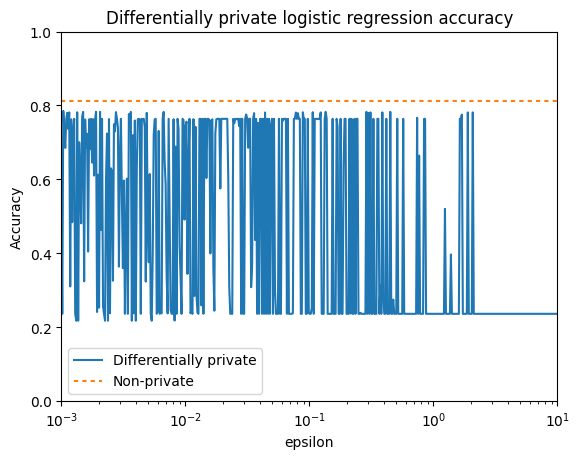

In [51]:
import matplotlib.pyplot as plt

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

### DecisionTree

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [54]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Niet-private accuracy:", accuracy_score(y_test, y_pred))

Niet-private accuracy: 0.8186229347091702


In [55]:
from diffprivlib.models import DecisionTreeClassifier as DPDecisionTreeClassifier

dp_clf = DPDecisionTreeClassifier(
    epsilon=1.0,
    bounds=(X_train.min(axis=0), X_train.max(axis=0)),
    classes=[" <=50K", " >50K"],
    max_depth=5,
    random_state=0
)

dp_clf.fit(X_train, y_train)
dp_y_pred = dp_clf.predict(X_test)

print("Private accuracy (epsilon=1.0):", accuracy_score(y_test, dp_y_pred))

Private accuracy (epsilon=1.0): 0.774890977212702


Model Evaluation with and without DP (𝜖 = 1.0)
We tested the impact of differential privacy using diffprivlib on two types of models:
•	A simple model: LogisticRegression
•	A complex model: DecisionTreeClassifier
All models were trained and evaluated on the same dataset: Adult Income Dataset from the UCI repository.
Accuracy Results
Model	Without DP	With DP (𝜖 = 1.0)	Accuracy Drop
Logistic Regression	81.25%	79.50%	-1.75%
Decision Tree	81.86%	77.49%	-4.37%
 
Interpretation
•	Both models maintain reasonable accuracy after applying differential privacy.
•	Logistic Regression shows minimal performance loss (only ~1.75%), suggesting it's well-suited for private learning.
•	Decision Trees experience a larger drop (~4.37%) due to:
o	Noise affecting decision splits
o	Sensitivity to small data variations
•	Overall, 𝜖 = 1.0 proves to be a practical choice, achieving privacy without heavily sacrificing accuracy.
 
 Limitations of diffprivlib
While diffprivlib is useful, it has some important limitations:
 Limited Model Support
•	Only basic models are supported:
o	No support for XGBoost, LightGBM, SVM, or Deep Learning (e.g., TensorFlow, PyTorch).
•	Not suitable for tasks in computer vision, natural language processing, or large-scale real-time systems.
 Manual Configuration Required
•	Some models require manual setting of:
o	data_norm or bounds
•	If skipped, the library estimates these from your data, causing a PrivacyLeakWarning and weakening privacy guarantees.
 Performance Trade-off
•	Stronger privacy (lower epsilon) = More noise = Lower accuracy.
•	Tree-based models (DecisionTree, RandomForest) are especially sensitive to added noise in split decisions.
 Not Designed for All Use Cases
•	Best suited for:
o	Educational and research applications
o	Privacy-aware experiments on structured/tabular data
•	Less suited for:
o	Multiclass classification
o	Large, unstructured datasets
 
 Specific Limitations: Tree-Based Models
Decision Trees
•	Randomized feature selection and thresholds reduce stability under DP.
•	Noise affects leaf predictions → accuracy becomes more volatile.
Random Forests
•	Built from multiple noisy trees.
•	Performance depends on dataset size and structure.
•	Extra randomness from DP can reduce overall performance.
 
 Summary
•	diffprivlib provides a practical and effective way to apply differential privacy to machine learning.
•	Logistic Regression works very well under DP.
•	Decision Trees remain useful, but are more sensitive to the added noise.
•	Epsilon = 1.0 yields a solid balance between privacy and utility.
•	While not suitable for every case, diffprivlib is a strong choice for privacy-preserving ML in research and prototyping.
